In [1]:
import pandas as pd

# Define the relative path to the CSV file
metadata_path = '../COVID-US/utils/LUSS_metadata.csv'

# Read the CSV file using the relative path
metadata = pd.read_csv(metadata_path)

# Display the data 
print(metadata.head())


                  id  LUSS filetype     source   probe  class     type
0  1_butterfly_covid   3.0      mp4  Butterfly  Convex  COVID     lung
1  2_butterfly_covid   2.0      mp4  Butterfly  Convex  COVID     lung
2  3_butterfly_covid   2.0      mp4  Butterfly  Convex  COVID     lung
3  4_butterfly_covid   2.0      mp4  Butterfly  Convex  COVID     lung
4  5_butterfly_covid   NaN      mp4  Butterfly  Convex  COVID  cardiac


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def parse_filename(filename):
    parts = filename.split('_')
    video_number = int(parts[0])
    return video_number

# Example usage
filename = "1_butterfly_covid_prc_convex_clean_frame0.jpg"
video_number = parse_filename(filename)
print(video_number)  # Output: 1


1


In [3]:
RESIZED_IMAGE= '../COVID-US/data/image/clean/resized'

def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Example usage
resized_dir = '../COVID-US/data/image/clean/resized'
ensure_directory_exists(RESIZED_IMAGE)


In [4]:
def preprocess_and_save_image(image_path, resized_dir, target_size=(224, 224), normalization_range=(0, 1)):
    filename = os.path.basename(image_path)
    resized_filename = filename.replace('.jpg', '_resized.jpg')
    resized_image_path = os.path.join(resized_dir, resized_filename)
    
    # Check if the resized image already exists
    if os.path.exists(resized_image_path):
        image = cv2.imread(resized_image_path)
        if image is not None:
            return image
    
    # If the resized image does not exist, create it
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, target_size)
        cv2.imwrite(resized_image_path, image)  # Save resized image
        
        # Normalize image
        image = image.astype('float32')
        if normalization_range == (0, 1):
            image /= 255.0
        elif normalization_range == (-1, 1):
            image = (image / 127.5) - 1.0
        return image
    return None


In [5]:
def load_and_preprocess_images(image_dir, resized_dir, metadata, target_size=(224, 224), normalization_range=(0, 1)):
    image_data = []
    labels = []
    probe_types = []
    image_paths = []
    
    ensure_directory_exists(resized_dir)
    
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            video_number = parse_filename(filename)
            img_path = os.path.join(image_dir, filename)
            image = preprocess_and_save_image(img_path, resized_dir, target_size, normalization_range)
            if image is not None:
                image_data.append(image)
                image_paths.append(img_path)
                
                # Extract corresponding metadata
                video_metadata = metadata[metadata['id'].str.startswith(str(video_number) + '_')]
                if not video_metadata.empty:
                    labels.append(video_metadata['class'].values[0])
                    probe_types.append(video_metadata['probe'].values[0])
                else:
                    print(f"No metadata found for video number {video_number}")

    return np.array(image_data), labels, probe_types, image_paths

CLEAN_IMAGE = '../COVID-US/data/image/clean'
RESIZED_IMAGE = '../COVID-US/data/image/clean/resized'
images, labels, probe_types, image_paths = load_and_preprocess_images(CLEAN_IMAGE, RESIZED_IMAGE, metadata)


In [6]:
# print(probe_types)

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Extract video IDs from image paths (assuming filenames are formatted as "videoID_frameID_resized.jpg")
video_ids = [os.path.basename(path).split('_')[0] for path in image_paths]

# Convert to NumPy array
video_ids = np.array(video_ids)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# One-hot encode probe types
probe_type_encoder = OneHotEncoder(sparse_output=False)
encoded_probe_types = probe_type_encoder.fit_transform(np.array(probe_types).reshape(-1, 1))

# Create a DataFrame with minimal information for splitting
data = pd.DataFrame({
    'video_id': video_ids,
    'label': encoded_labels
})

# Map video IDs to their corresponding labels
video_to_label = data.groupby('video_id')['label'].apply(lambda x: x.mode()[0]).to_dict()

# Get the label for each unique video ID
unique_video_ids = data['video_id'].unique()
video_labels = np.array([video_to_label[vid] for vid in unique_video_ids])

# Split video IDs into training, validation, and test sets
train_videos, test_videos = train_test_split(unique_video_ids, test_size=0.1, random_state=42, stratify=video_labels)
train_labels = np.array([video_to_label[vid] for vid in train_videos])
train_videos, val_videos = train_test_split(train_videos, test_size=0.2, random_state=42, stratify=train_labels)

# Assign frames to the respective sets based on their video split
train_indices = data[data['video_id'].isin(train_videos)].index
val_indices = data[data['video_id'].isin(val_videos)].index
test_indices = data[data['video_id'].isin(test_videos)].index

# Use indices to extract the actual data
X_train = np.stack([images[i] for i in train_indices])
y_train = encoded_labels[train_indices]
probe_train = np.stack([encoded_probe_types[i] for i in train_indices])

X_val = np.stack([images[i] for i in val_indices])
y_val = encoded_labels[val_indices]
probe_val = np.stack([encoded_probe_types[i] for i in val_indices])

X_test = np.stack([images[i] for i in test_indices])
y_test = encoded_labels[test_indices]
probe_test = np.stack([encoded_probe_types[i] for i in test_indices])

# Validate input shapes
print("X_train shape:", X_train.shape)
print("probe_train shape:", probe_train.shape)
print("X_val shape:", X_val.shape)
print("probe_val shape:", probe_val.shape)
print("X_test shape:", X_test.shape)
print("probe_test shape:", probe_test.shape)


X_train shape: (21263, 224, 224, 3)
probe_train shape: (21263, 2)
X_val shape: (4866, 224, 224, 3)
probe_val shape: (4866, 2)
X_test shape: (3516, 224, 224, 3)
probe_test shape: (3516, 2)


In [8]:
# Record the distribution of labels in each set
train_label_distribution = pd.Series(y_train).value_counts().sort_index()
val_label_distribution = pd.Series(y_val).value_counts().sort_index()
test_label_distribution = pd.Series(y_test).value_counts().sort_index()

# Map encoded labels back to original class names
label_class_names = label_encoder.inverse_transform(train_label_distribution.index)

# Create a DataFrame to store the distributions with class names
label_distributions = pd.DataFrame({
    'Class Name': label_class_names,
    'Train': train_label_distribution.values,
    'Validation': val_label_distribution.values,
    'Test': test_label_distribution.values
}).set_index('Class Name')

# Display the DataFrame
print(label_distributions)


            Train  Validation  Test
Class Name                         
COVID        6376        1875   970
Normal       2093         579   209
Other        7844        1115  1206
Pneumonia    4950        1297  1131


<Figure size 1200x600 with 0 Axes>

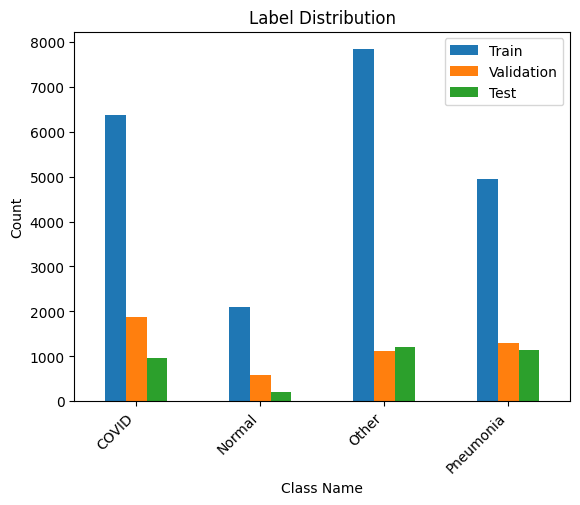

In [9]:
# Plot the label distributions
plt.figure(figsize=(12, 6))
label_distributions.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.show()


In [10]:
import os
import certifi
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Concatenate
from tensorflow.keras.applications import (
    MobileNetV2, InceptionV3, InceptionResNetV2, Xception, ResNet50V2,
    EfficientNetB4, DenseNet121, DenseNet169, DenseNet201
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

def build_baseline_model(base_model, input_shape=(224, 224, 3), num_classes=4):
    base_model = base_model(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    cnn_input = Input(shape=input_shape, name='cnn_input')
    cnn_output = base_model(cnn_input)
    cnn_output = Flatten()(cnn_output)
    final_output = Dense(num_classes, activation='softmax')(cnn_output)

    model = Model(inputs=cnn_input, outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def build_multimodal_model(base_model, input_shape=(224, 224, 3), num_classes=4):
    base_model = base_model(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    
    cnn_input = Input(shape=input_shape, name='cnn_input')
    cnn_output = base_model(cnn_input)
    cnn_output = Flatten()(cnn_output)

    probe_input_shape = (encoded_probe_types.shape[1],)
    probe_input = Input(shape=probe_input_shape, name='probe_input')
    x = Dense(1024, activation='relu')(probe_input)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)

    combined = Concatenate()([cnn_output, x])
    final_output = Dense(num_classes, activation='softmax')(combined)

    model = Model(inputs=[cnn_input, probe_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [11]:
def train_model(model, X_train, y_train, probe_train, X_val, y_val, probe_val, epochs=20, batch_size=16, multimodal=True):
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=1e-6)
    ]
    
    if multimodal:
        history = model.fit(
            [X_train, probe_train], y_train,
            validation_data=([X_val, probe_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
    else:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
    return history

from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, probe_test, multimodal=True):
    if multimodal:
        y_pred = model.predict([X_test, probe_test])
    else:
        y_pred = model.predict(X_test)
    
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_classes)
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('Confusion Matrix:')
    print(conf_matrix)
    return accuracy, conf_matrix



In [12]:
# Validate input shapes
print("X_train shape:", X_train.shape)
print("probe_train shape:", probe_train.shape)
print("X_val shape:", X_val.shape)
print("probe_val shape:", probe_val.shape)
print("X_test shape:", X_test.shape)
print("probe_test shape:", probe_test.shape)


X_train shape: (21263, 224, 224, 3)
probe_train shape: (21263, 2)
X_val shape: (4866, 224, 224, 3)
probe_val shape: (4866, 2)
X_test shape: (3516, 224, 224, 3)
probe_test shape: (3516, 2)


In [13]:
# # Step 1: Modify `run_model_evaluation` to return metrics
# def run_model_evaluation(base_model_name, base_model, X_train, y_train, probe_train, X_val, y_val, probe_val, X_test, y_test, probe_test):
#     metrics = {
#         'model_name': base_model_name,
#         'baseline': {},
#         'multimodal': {}
#     }
    
#     print(f'Evaluating {base_model_name} Baseline Model')
#     baseline_model = build_baseline_model(base_model)
#     baseline_history = train_model(baseline_model, X_train, y_train, None, X_val, y_val, None, multimodal=False)
#     baseline_accuracy, baseline_conf_matrix = evaluate_model(baseline_model, X_test, y_test, None, multimodal=False)
    
#     metrics['baseline']['history'] = baseline_history.history
#     metrics['baseline']['accuracy'] = baseline_accuracy
#     metrics['baseline']['conf_matrix'] = baseline_conf_matrix
    
#     print(f'Evaluating {base_model_name} Multimodal Model')
#     multimodal_model = build_multimodal_model(base_model)
#     multimodal_history = train_model(multimodal_model, X_train, y_train, probe_train, X_val, y_val, probe_val, multimodal=True)
#     multimodal_accuracy, multimodal_conf_matrix = evaluate_model(multimodal_model, X_test, y_test, probe_test, multimodal=True)
    
#     metrics['multimodal']['history'] = multimodal_history.history
#     metrics['multimodal']['accuracy'] = multimodal_accuracy
#     metrics['multimodal']['conf_matrix'] = multimodal_conf_matrix
    
#     return metrics


In [14]:
def run_model_evaluation(base_model_name, base_model, X_train, y_train, probe_train, X_val, y_val, probe_val, X_test, y_test, probe_test, results, epochs=20):
    metrics = {
        'model_name': base_model_name,
        'baseline': {},
        'multimodal': {}
    }
    
    # Define paths for model weights
    baseline_weights_path = f'./model_weights/{base_model_name}_baseline.weights.h5'
    multimodal_weights_path = f'./model_weights/{base_model_name}_multimodal.weights.h5'
    
    # Check if the model results already exist in the results list
    existing_model_metrics = next((item for item in results if item['model_name'] == base_model_name), None)
    
    retrain_baseline = True
    retrain_multimodal = True

    # Check conditions for skipping baseline training
    if existing_model_metrics:
        baseline_history_len = len(existing_model_metrics['baseline'].get('history', {}).get('accuracy', []))
        if os.path.exists(baseline_weights_path) and baseline_history_len == epochs:
            retrain_baseline = False

    # Check conditions for skipping multimodal training
    if existing_model_metrics:
        multimodal_history_len = len(existing_model_metrics['multimodal'].get('history', {}).get('accuracy', []))
        if os.path.exists(multimodal_weights_path) and multimodal_history_len == epochs:
            retrain_multimodal = False

    # Evaluate baseline model
    print(f'Evaluating {base_model_name} Baseline Model')
    baseline_model = build_baseline_model(base_model)
    
    if retrain_baseline:
        baseline_history = train_model(baseline_model, X_train, y_train, None, X_val, y_val, None, epochs=epochs, multimodal=False)
        baseline_model.save_weights(baseline_weights_path)
        metrics['baseline']['history'] = baseline_history.history
    else:
        print(f"Loading existing weights for {base_model_name} baseline model.")
        baseline_model.load_weights(baseline_weights_path)
        metrics['baseline'] = existing_model_metrics['baseline']

    baseline_accuracy, baseline_conf_matrix = evaluate_model(baseline_model, X_test, y_test, None, multimodal=False)
    metrics['baseline']['accuracy'] = baseline_accuracy
    metrics['baseline']['conf_matrix'] = baseline_conf_matrix
    
    # Evaluate multimodal model
    print(f'Evaluating {base_model_name} Multimodal Model')
    multimodal_model = build_multimodal_model(base_model)
    
    if retrain_multimodal:
        multimodal_history = train_model(multimodal_model, X_train, y_train, probe_train, X_val, y_val, probe_val, epochs=epochs, multimodal=True)
        multimodal_model.save_weights(multimodal_weights_path)
        metrics['multimodal']['history'] = multimodal_history.history
    else:
        print(f"Loading existing weights for {base_model_name} multimodal model.")
        multimodal_model.load_weights(multimodal_weights_path)
        metrics['multimodal'] = existing_model_metrics['multimodal']

    multimodal_accuracy, multimodal_conf_matrix = evaluate_model(multimodal_model, X_test, y_test, probe_test, multimodal=True)
    metrics['multimodal']['accuracy'] = multimodal_accuracy
    metrics['multimodal']['conf_matrix'] = multimodal_conf_matrix
    
    return metrics


In [15]:
import os
import pickle

# Ensure the directory for storing model weights exists
os.makedirs('./model_weights', exist_ok=True)

# Check if results.pkl exists
if os.path.exists('results.pkl'):
    with open('results.pkl', 'rb') as file:
        results = pickle.load(file)
else: results = []

models = { 
    "MobileNetV2": MobileNetV2,
    "InceptionV3": InceptionV3,
    "InceptionResNetV2": InceptionResNetV2,
    "Xception": Xception,
    "ResNet50V2": ResNet50V2,
    "EfficientNetB4": EfficientNetB4,
    "DenseNet121": DenseNet121,
    "DenseNet169": DenseNet169,
    "DenseNet201": DenseNet201
}

# Store results in a list
for model_name, model_class in models.items():
    metrics = run_model_evaluation(
        model_name, 
        model_class, 
        X_train, y_train, probe_train, 
        X_val, y_val, probe_val, 
        X_test, y_test, probe_test, 
        results
    )
    # Update the results list, ensuring no duplicates
    results = [item for item in results if item['model_name'] != model_name]
    results.append(metrics)

# Save the results to a file
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Step 3: Convert results to DataFrame
import pandas as pd

results_df = pd.DataFrame(results)

accuracy_data = []
for result in results:
    accuracy_data.append({
        'model_name': result['model_name'],
        'model_type': 'baseline',
        'accuracy': result['baseline']['accuracy']
    })
    accuracy_data.append({
        'model_name': result['model_name'],
        'model_type': 'multimodal',
        'accuracy': result['multimodal']['accuracy']
    })

accuracy_df = pd.DataFrame(accuracy_data)


Evaluating MobileNetV2 Baseline Model
Loading existing weights for MobileNetV2 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step
Accuracy: 54.49%
Confusion Matrix:
[[370  28 482  90]
 [  0   0 209   0]
 [207   0 988  11]
 [ 58   1 514 558]]
Evaluating MobileNetV2 Multimodal Model
Loading existing weights for MobileNetV2 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step
Accuracy: 54.84%
Confusion Matrix:
[[ 370    1  524   75]
 [   0    0  209    0]
 [ 171    0 1023   12]
 [  42    0  554  535]]
Evaluating InceptionV3 Baseline Model
Loading existing weights for InceptionV3 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step
Accuracy: 50.91%
Confusion Matrix:
[[587   0 365  18]
 [ 55   0 154   0]
 [ 74   0 714 418]
 [440   0 202 489]]
Evaluating InceptionV3 Multimodal Model
Loading existing weights for InceptionV3 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step
Accuracy: 53.64%
Confusion Matrix:
[[602   0 332  36]
 [ 16   0 186   7]
 [ 81   0 736 389]
 [110   0 473 548]]
Evaluating InceptionResNetV2 Baseline Model
Loading existing weights for InceptionResNetV2 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 89s 795ms/step
Accuracy: 48.58%
Confusion Matrix:
[[303  81 560  26]
 [  1   0 207   1]
 [121   4 502 579]
 [106   0 122 903]]
Evaluating InceptionResNetV2 Multimodal Model
Loading existing weights for InceptionResNetV2 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 88s 787ms/step
Accuracy: 51.39%
Confusion Matrix:
[[304 105 517  44]
 [  4  18 187   0]
 [101   4 532 569]
 [ 92   0  86 953]]
Evaluating Xception Baseline Model
Loading existing weights for Xception baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 67s 608ms/step
Accuracy: 55.86%
Confusion Matrix:
[[573  13 378   6]
 [ 51   0 158   0]
 [ 65   0 842 299]
 [516   0  66 549]]
Evaluating Xception Multimodal Model
Loading existing weights for Xception multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 67s 609ms/step
Accuracy: 55.29%
Confusion Matrix:
[[548  42 373   7]
 [ 52   0 157   0]
 [ 77  16 809 304]
 [500   0  44 587]]
Evaluating ResNet50V2 Baseline Model
Loading existing weights for ResNet50V2 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step
Accuracy: 59.22%
Confusion Matrix:
[[575 197  51 147]
 [  0   0 209   0]
 [180  25 520 481]
 [ 53   0  91 987]]
Evaluating ResNet50V2 Multimodal Model
Loading existing weights for ResNet50V2 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step
Accuracy: 60.84%
Confusion Matrix:
[[ 547   24   90  309]
 [   0    0  209    0]
 [ 173   77  548  408]
 [  47    0   40 1044]]
Evaluating EfficientNetB4 Baseline Model
Loading existing weights for EfficientNetB4 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 593ms/step
Accuracy: 58.11%
Confusion Matrix:
[[683  81  89 117]
 [  0   0 209   0]
 [ 39   0 689 478]
 [  1   6 453 671]]
Evaluating EfficientNetB4 Multimodal Model
Loading existing weights for EfficientNetB4 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 585ms/step
Accuracy: 52.45%
Confusion Matrix:
[[496 243 143  88]
 [  0   5 204   0]
 [ 36   0 731 439]
 [  0   3 516 612]]
Evaluating DenseNet121 Baseline Model
Loading existing weights for DenseNet121 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 490ms/step
Accuracy: 50.14%
Confusion Matrix:
[[351   4 278 337]
 [  0   0 209   0]
 [113   0 667 426]
 [104   0 282 745]]
Evaluating DenseNet121 Multimodal Model
Loading existing weights for DenseNet121 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 492ms/step
Accuracy: 59.07%
Confusion Matrix:
[[387  50 278 255]
 [  0   0 209   0]
 [  0   0 792 414]
 [ 36   8 189 898]]
Evaluating DenseNet169 Baseline Model
Loading existing weights for DenseNet169 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 67s 595ms/step
Accuracy: 62.60%
Confusion Matrix:
[[514   0 231 225]
 [  4  21 184   0]
 [  0   1 736 469]
 [ 15  10 176 930]]
Evaluating DenseNet169 Multimodal Model
Loading existing weights for DenseNet169 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 66s 590ms/step
Accuracy: 63.05%
Confusion Matrix:
[[680   0 120 170]
 [  0  53 156   0]
 [155   0 569 482]
 [ 57  14 145 915]]
Evaluating DenseNet201 Baseline Model
Loading existing weights for DenseNet201 baseline model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step
Accuracy: 51.51%
Confusion Matrix:
[[576   0 155 239]
 [  1  29 179   0]
 [  0  20 665 521]
 [123   2 465 541]]
Evaluating DenseNet201 Multimodal Model
Loading existing weights for DenseNet201 multimodal model.


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 85s 759ms/step
Accuracy: 62.43%
Confusion Matrix:
[[ 604    0  221  145]
 [   4   45  160    0]
 [ 163    0  537  506]
 [  69   13   40 1009]]


In [16]:
print(accuracy_df)

           model_name  model_type  accuracy
0         MobileNetV2    baseline  0.544937
1         MobileNetV2  multimodal  0.548350
2         InceptionV3    baseline  0.509101
3         InceptionV3  multimodal  0.536405
4   InceptionResNetV2    baseline  0.485779
5   InceptionResNetV2  multimodal  0.513936
6            Xception    baseline  0.558589
7            Xception  multimodal  0.552901
8          ResNet50V2    baseline  0.592150
9          ResNet50V2  multimodal  0.608362
10     EfficientNetB4    baseline  0.581058
11     EfficientNetB4  multimodal  0.524460
12        DenseNet121    baseline  0.501422
13        DenseNet121  multimodal  0.590728
14        DenseNet169    baseline  0.625995
15        DenseNet169  multimodal  0.630546
16        DenseNet201    baseline  0.515074
17        DenseNet201  multimodal  0.624289


In [17]:
print(results)

[{'model_name': 'MobileNetV2', 'baseline': {'history': {'accuracy': [0.9652917981147766, 0.979636013507843, 0.9812350273132324, 0.9791656732559204, 0.984480082988739, 0.9834924340248108, 0.9847622513771057, 0.9847622513771057, 0.9863612651824951, 0.9858909845352173, 0.9865493774414062, 0.9859380125999451, 0.9861261248588562, 0.9868316054344177, 0.9859850406646729, 0.9865023493766785, 0.9869256615638733, 0.9865493774414062, 0.986173152923584, 0.9869726896286011], 'loss': [0.12098097801208496, 0.10226666182279587, 0.08671166747808456, 0.1079336628317833, 0.03945382311940193, 0.035444747656583786, 0.026440482586622238, 0.025758834555745125, 0.024002423509955406, 0.023941906169056892, 0.023604637011885643, 0.023658812046051025, 0.023555144667625427, 0.023458819836378098, 0.02347288653254509, 0.023337367922067642, 0.02310115098953247, 0.02298569306731224, 0.023065906018018723, 0.022986404597759247], 'val_accuracy': [0.5795314311981201, 0.6054254174232483, 0.5871351957321167, 0.5926839113235

In [18]:
def print_model_summaries(base_model_name, base_model_class):
    # Define paths for model weights
    baseline_weights_path = f'./model_weights/{base_model_name}_baseline.weights.h5'
    multimodal_weights_path = f'./model_weights/{base_model_name}_multimodal.weights.h5'
    
    # Build and load the baseline model
    print(f"Building and loading the baseline model for {base_model_name}...")
    baseline_model = build_baseline_model(base_model_class)
    if os.path.exists(baseline_weights_path):
        baseline_model.load_weights(baseline_weights_path)
        print(f"Loaded weights from {baseline_weights_path}")
    else:
        print(f"Weights file for baseline model not found at {baseline_weights_path}")
    
    # Build and load the multimodal model
    print(f"Building and loading the multimodal model for {base_model_name}...")
    multimodal_model = build_multimodal_model(base_model_class)
    if os.path.exists(multimodal_weights_path):
        multimodal_model.load_weights(multimodal_weights_path)
        print(f"Loaded weights from {multimodal_weights_path}")
    else:
        print(f"Weights file for multimodal model not found at {multimodal_weights_path}")
    
    # Print summaries
    print(f"\nSummary for Baseline Model ({base_model_name}):")
    baseline_model.summary()
    
    print(f"\nSummary for Multimodal Model ({base_model_name}):")
    multimodal_model.summary()

print_model_summaries("MobileNetV2",MobileNetV2)

Building and loading the baseline model for MobileNetV2...


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded weights from ./model_weights/MobileNetV2_baseline.weights.h5
Building and loading the multimodal model for MobileNetV2...
Loaded weights from ./model_weights/MobileNetV2_multimodal.weights.h5

Summary for Baseline Model (MobileNetV2):


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)          │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Summary for Multimodal Model (MobileNetV2):


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ probe_input         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 1024)      │      3,072 │ probe_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 1024)      │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 1024)      │  1,049,600 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ cnn_input[0][0]   │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 1024)      │          0 │ dense_47[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 62720)     │          0 │ mobilenetv2_1.00… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 512)       │    524,800 │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 63232)     │          0 │ flatten_19[0][0], │
│ (Concatenate)       │                   │            │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 4)         │    252,932 │ concatenate_13[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,088,388 (15.60 MB)

 Trainable params: 1,830,404 (6.98 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return accuracy, precision, recall, f1

In [20]:
# def evaluate_trained_models(models, X_test, y_test, probe_test, results):
#     evaluation_data = []
    
#     for model_name, model_class in models.items():
#         # Define paths for model weights
#         baseline_weights_path = f'./model_weights/{model_name}_baseline.weights.h5'
#         multimodal_weights_path = f'./model_weights/{model_name}_multimodal.weights.h5'
        
#         # Evaluate baseline model
#         print(f'Evaluating {model_name} Baseline Model')
#         baseline_model = build_baseline_model(model_class)
#         if os.path.exists(baseline_weights_path):
#             baseline_model.load_weights(baseline_weights_path)
#             y_pred_baseline = np.argmax(baseline_model.predict(X_test), axis=1)
#             accuracy_baseline, precision_baseline, recall_baseline, f1_baseline = calculate_metrics(y_test, y_pred_baseline)
#             params_baseline = baseline_model.count_params()
#         else:
#             print(f"Weights for baseline model not found at {baseline_weights_path}")
#             continue
        
#         # Evaluate multimodal model
#         print(f'Evaluating {model_name} Multimodal Model')
#         multimodal_model = build_multimodal_model(model_class)
#         if os.path.exists(multimodal_weights_path):
#             multimodal_model.load_weights(multimodal_weights_path)
#             y_pred_multimodal = np.argmax(multimodal_model.predict([X_test, probe_test]), axis=1)
#             accuracy_multimodal, precision_multimodal, recall_multimodal, f1_multimodal = calculate_metrics(y_test, y_pred_multimodal)
#             params_multimodal = multimodal_model.count_params()
#         else:
#             print(f"Weights for multimodal model not found at {multimodal_weights_path}")
#             continue
        
#         evaluation_data.append({
#             "model_name": model_name,
#             "baseline_params": params_baseline,
#             "baseline_accuracy": accuracy_baseline,
#             "baseline_precision": precision_baseline,
#             "baseline_recall": recall_baseline,
#             "baseline_f1": f1_baseline,
#             "multimodal_params": params_multimodal,
#             "multimodal_accuracy": accuracy_multimodal,
#             "multimodal_precision": precision_multimodal,
#             "multimodal_recall": recall_multimodal,
#             "multimodal_f1": f1_multimodal
#         })
    
#     return evaluation_data

In [21]:
# evaluation_results = evaluate_trained_models(models, X_test, y_test, probe_test, results)

# # Print the evaluation results in the desired format
# import pandas as pd

# df_results = pd.DataFrame(evaluation_results)
# print(df_results)


In [22]:
# df_results


In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return accuracy, precision, recall, f1

def evaluate_trained_models(models, X_test, y_test, probe_test):
    evaluation_data = []
    
    for model_name, model_class in models.items():
        # Define paths for model weights
        baseline_weights_path = f'./model_weights/{model_name}_baseline.weights.h5'
        multimodal_weights_path = f'./model_weights/{model_name}_multimodal.weights.h5'
        
        # Evaluate baseline model
        print(f'Evaluating {model_name} Baseline Model')
        baseline_model = build_baseline_model(model_class)
        if os.path.exists(baseline_weights_path):
            baseline_model.load_weights(baseline_weights_path)
            y_pred_baseline = np.argmax(baseline_model.predict(X_test), axis=1)
            accuracy_baseline, precision_baseline, recall_baseline, f1_baseline = calculate_metrics(y_test, y_pred_baseline)
            params_baseline = baseline_model.count_params()
            
            evaluation_data.append({
                "model_name": model_name,
                "model_type": "baseline",
                "params": params_baseline,
                "accuracy": accuracy_baseline,
                "precision": precision_baseline,
                "recall": recall_baseline,
                "f1": f1_baseline
            })
        else:
            print(f"Weights for baseline model not found at {baseline_weights_path}")
            continue
        
        # Evaluate multimodal model
        print(f'Evaluating {model_name} Multimodal Model')
        multimodal_model = build_multimodal_model(model_class)
        if os.path.exists(multimodal_weights_path):
            multimodal_model.load_weights(multimodal_weights_path)
            y_pred_multimodal = np.argmax(multimodal_model.predict([X_test, probe_test]), axis=1)
            accuracy_multimodal, precision_multimodal, recall_multimodal, f1_multimodal = calculate_metrics(y_test, y_pred_multimodal)
            params_multimodal = multimodal_model.count_params()
            
            evaluation_data.append({
                "model_name": model_name,
                "model_type": "multimodal",
                "params": params_multimodal,
                "accuracy": accuracy_multimodal,
                "precision": precision_multimodal,
                "recall": recall_multimodal,
                "f1": f1_multimodal
            })
        else:
            print(f"Weights for multimodal model not found at {multimodal_weights_path}")
            continue
    
    df_results = pd.DataFrame(evaluation_data)
    return df_results


In [24]:
df_results = evaluate_trained_models(models, X_test, y_test, probe_test)

Evaluating MobileNetV2 Baseline Model
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 149ms/step
Evaluating MobileNetV2 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step
Evaluating InceptionV3 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step
Evaluating InceptionV3 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step
Evaluating InceptionResNetV2 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 88s 783ms/step
Evaluating InceptionResNetV2 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 814ms/step
Evaluating Xception Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 617ms/step
Evaluating Xception Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 612ms/step
Evaluating ResNet50V2 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 473ms/step
Evaluating ResNet50V2 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 52s 467ms/step
Evaluating EfficientNetB4 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 72s 642ms/step
Evaluating EfficientNetB4 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 605ms/step
Evaluating DenseNet121 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step
Evaluating DenseNet121 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 55s 493ms/step
Evaluating DenseNet169 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 608ms/step
Evaluating DenseNet169 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 68s 603ms/step
Evaluating DenseNet201 Baseline Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 88s 786ms/step
Evaluating DenseNet201 Multimodal Model


/Users/jacksonc/Desktop/Project/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


110/110 ━━━━━━━━━━━━━━━━━━━━ 89s 790ms/step


In [25]:
df_results

,model_name,model_type,params,accuracy,precision,recall,f1
0,MobileNetV2,baseline,2508868,54.493743,58.765340,54.493743,52.715298
1,MobileNetV2,multimodal,4088388,54.835040,60.366897,54.835040,52.739745
2,InceptionV3,baseline,22007588,50.910125,48.080548,50.910125,49.082164
3,InceptionV3,multimodal,23587108,53.640501,53.134401,53.640501,52.586495
4,InceptionResNetV2,baseline,54490340,48.577929,47.370282,48.577929,46.404017
5,InceptionResNetV2,multimodal,56069860,51.393629,50.961373,51.393629,49.209224
6,Xception,baseline,21262892,55.858931,53.798241,55.858931,54.126269
7,Xception,multimodal,22842412,55.290102,53.936037,55.290102,54.131547
8,ResNet50V2,baseline,23966212,59.215017,59.769347,59.215017,58.142669
9,ResNet50V2,multimodal,25545732,60.836177,59.936380,60.836177,58.561482
